<a href="https://colab.research.google.com/github/summiyak/NLP_Final_project/blob/main/Dataset_Cartography_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/')

In [ ]:
!pip install -r /content/drive/MyDrive/electra/fp-dataset-artifacts-main/requirements.txt

In [3]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import wandb

# Step 1: Load the HANS dataset
# Convert to Hugging Face Dataset
# Use 90% for training and 10% for validation
dataset = load_dataset("snli")
train_dataset = dataset["train"]
train_dataset = train_dataset.train_test_split(test_size=0.50)["train"]

eval_dataset = dataset["validation"]
eval_dataset = eval_dataset.train_test_split(test_size=0.50)["train"]



print(len(train_dataset))
print(len(eval_dataset))

# Load Electra Small model and tokenizer
model_name = "/content/drive/MyDrive/electra/trained_model/"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length", max_length=128)



# Fix labels to ensure compatibility
def fix_label(examples):
    examples['label'] = [abs(int(label)) for label in examples['label']]
    return examples


train_dataset = train_dataset.map(fix_label, batched=True)
eval_dataset = eval_dataset.map(fix_label, batched=True)


# Step 2: Load the Tokenizer
# Replace 'google/electra-base-discriminator' with your model's tokenizer if different

#model = AutoModelForSequenceClassification.from_pretrained(model_name)  # 3 labels for SNLI


train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = eval_dataset.map(preprocess_function, batched=True)


# Step 3: Split the Dataset (Optional)


print("Train Data size: ",len(train_dataset))
print("Eval Data size: ",len(eval_dataset))

# Step 4: Load the Pretrained Model
# Replace '/path/to/your/pretrained_model' with the directory where your model is saved
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,  # Path to your pretrained model
    num_labels=3  # HANS has 2 labels: entailment and non-entailment
)

# Step 5: Define Training Arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/electra/cartography/cart_final/model/",  # Directory to save the fine-tuned model
    evaluation_strategy="epoch",          # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save the model at the end of each epoch
    learning_rate=5e-5,                   # Fine-tuning learning rate
    per_device_train_batch_size=16,       # Adjust based on GPU memory
    per_device_eval_batch_size=32,
    num_train_epochs=1,                   # Number of fine-tuning epochs
    weight_decay=0.01,                    # Regularization
    logging_dir="/content/drive/MyDrive/electra/cartography/cart_final/hans_logs",                 # Directory for logs
    logging_steps=100,                    # Log every 100 steps
    save_total_limit=3,                   # Keep only the last 2 checkpoints
    load_best_model_at_end=True,          # Load the best model after training
    fp16=True,                            # Enable mixed precision for faster training
    gradient_accumulation_steps=2
)

wandb.init(project="cartography_final")
# Step 6: Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# Step 7: Start Fine-tuning

num_passes = 1
all_train_probs = []

for epoch in range(3):
    trainer.train()

    # Collect predictions for variability calculation
    epoch_probs = []
    for _ in range(num_passes):
        predictions = trainer.predict(train_dataset)
        probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
        #print(probs)
        epoch_probs.append(probs)
    all_train_probs.append(np.array(epoch_probs))
wandb.finish()
all_train_probs = np.array(all_train_probs)


# Example NumPy array (replace with your actual data)

# File path
file_path = "/content/drive/MyDrive/electra/cartography/cart_final/train_probs.npy"

# Save the array to the file
np.save(file_path, all_train_probs)

print(f"NumPy array saved to: {file_path}")

# Step 8: Save the Fine-tuned Model
trainer.save_model("/content/drive/MyDrive/electra/cartography/cart_final/model")
tokenizer.save_pretrained("/content/drive/MyDrive/electra/cartography/cart_final/model")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

275076
5000


Map:   0%|          | 0/275076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/275076 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Train Data size:  275076
Eval Data size:  5000


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-3-dcc65964e421>:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


NumPy array saved to: /content/drive/MyDrive/electra/cartography/cart_final/train_probs.npy


('/content/drive/MyDrive/electra/cartography/cart_final/model/tokenizer_config.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/special_tokens_map.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/vocab.txt',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/added_tokens.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/tokenizer.json')

Evaluating the pretrained model

In [36]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset snli --model /content/drive/MyDrive/electra/cartography/cart_final/model/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2024-11-28 16:40:39.742603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 16:40:39.766804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 16:40:39.773903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 16:40:39.791664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimiz

In [3]:
import os, json
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt


data = np.load('/content/drive/MyDrive/electra/cartography/cart_final/train_probs.npy')
all_train_probs = data
print(np.shape(all_train_probs))

(3, 1, 275076, 3)


In [4]:
import numpy as np

def calculate_variability(predicted_probs, true_labels):
    """
    Calculate variability of model-predicted probabilities.

    Args:
        predicted_probs (numpy.ndarray): Array of shape (epochs, examples, classes),
                                          containing predicted probabilities for each class.
        true_labels (numpy.ndarray): Array of shape (examples,), containing true labels.

    Returns:
        numpy.ndarray: Variability for each example, shape (examples,).
    """
    # Number of epochs and examples
    epochs,passes, examples, classes = np.shape(predicted_probs)

    # Get the predicted probabilities for the true label of each example across epochs
    variability =[0]*examples
    for i in range(examples) :
            temp = []
            for j in range(epochs) :
                temp.append(all_train_probs[j][0][i][true_labels[i]])
            #print(temp)
            variability[i] = np.std(temp)

    return variability

In [5]:
dataset = load_dataset("snli")
train_dataset = dataset["train"]
train_dataset = train_dataset.train_test_split(test_size=0.50)["train"]

# Fix labels to ensure compatibility
def fix_label(examples):
    examples['label'] = [abs(int(label)) for label in examples['label']]
    return examples


eval_dataset = dataset["validation"]
eval_dataset = eval_dataset.train_test_split(test_size=0.50)["train"]
train_dataset = train_dataset.map(fix_label, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Map:   0%|          | 0/275076 [00:00<?, ? examples/s]

In [6]:
true_labels = np.array(train_dataset['label'])
variability = calculate_variability(all_train_probs, true_labels)
print(variability)

[0.17809114, 0.029446315, 0.025637997, 0.0058571915, 0.00016979147, 0.033567157, 0.0005723886, 0.029406086, 0.14448343, 2.7148872e-05, 0.0002656393, 0.00023598071, 0.009075833, 8.281202e-05, 0.041190367, 0.0001654852, 0.0005922134, 0.00051091437, 0.007465742, 0.0022820376, 0.0069373245, 0.00665616, 0.00041438433, 0.0020878704, 0.0015643771, 0.0177725, 0.0017170137, 8.241938e-05, 0.0005732412, 0.00064427283, 0.0021716054, 0.040214103, 0.00018334451, 0.00035489674, 0.00073497684, 0.02142912, 4.2336116e-05, 0.034985885, 0.00085173734, 0.0013002392, 0.00014551869, 0.0788878, 0.00014087932, 0.11854586, 0.001954436, 0.107021086, 0.028923087, 0.001541309, 0.000108804124, 0.006903992, 0.00061117334, 0.011943285, 0.0003973092, 0.0066433847, 0.030248346, 0.03383463, 0.017492207, 9.996771e-05, 0.026284749, 0.01263352, 0.00025004402, 0.003189008, 0.0027824992, 0.0015190741, 0.0012159201, 0.0017383115, 0.008023517, 0.00068933674, 7.110336e-05, 0.026066666, 0.0047156606, 0.07911234, 0.009369218, 0.0

In [7]:
print(variability[1])

0.029446315


In [11]:
print(np.shape(variability))

(275076,)


In [8]:
# Variability and confidence classification
final_probs = np.mean(all_train_probs, axis=0)  # Average probabilities from the last epoch
std_devs = np.std(all_train_probs, axis=0)     # Standard deviation for variability
confidences = np.max(final_probs, axis=-1)


In [9]:
confidence_threshold_upper = 0.75
confidence_threshold_lower = 0.5
variability_threshold = 0.2


In [10]:
variability = np.array(variability)
easy_to_learn = (confidences >= confidence_threshold_upper) & (variability <= variability_threshold)
hard_to_learn = (confidences <= confidence_threshold_lower) & (variability <= variability_threshold)
ambiguous = ~((confidences >= confidence_threshold_upper) & (variability <= variability_threshold) | (confidences <= confidence_threshold_lower) & (variability <= variability_threshold))

# Summary statistics
num_easy = np.sum(easy_to_learn)
num_hard = np.sum(hard_to_learn)
num_ambiguous = np.sum(ambiguous)

print(f"Easy to learn examples: {num_easy}")
print(f"Hard to learn examples: {num_hard}")
print(f"Ambiguous examples: {num_ambiguous}")
print(f"Total examples: {num_easy + num_hard + num_ambiguous}")


Easy to learn examples: 253931
Hard to learn examples: 2466
Ambiguous examples: 18679
Total examples: 275076


In [11]:
ambiguous_indices = np.where(ambiguous)[1]  # Get indices where ambiguous is True
hard_indices = np.where(hard_to_learn)[1]  # Get indices where hard_to_learn is True
easy_indices = np.where(easy_to_learn)[1]  # Get indices where easy_to_learn is True

In [30]:
ambiguous_variability = variability[ambiguous_indices]
sorted_indices = ambiguous_indices[np.argsort(-ambiguous_variability)]  # Descending order

ambiguous_variability = variability[sorted_indices]
print(ambiguous_variability)
ambiguous_indices = sorted_indices

[4.4913059e-01 4.3438986e-01 4.3313381e-01 ... 2.9573195e-05 2.3119002e-05
 1.9002498e-05]


In [12]:
print(ambiguous_indices)

[     0     41     43 ... 275017 275065 275072]


In [31]:
print(ambiguous_indices)

[ 94921 167659 245351 ... 108817  27553 104421]


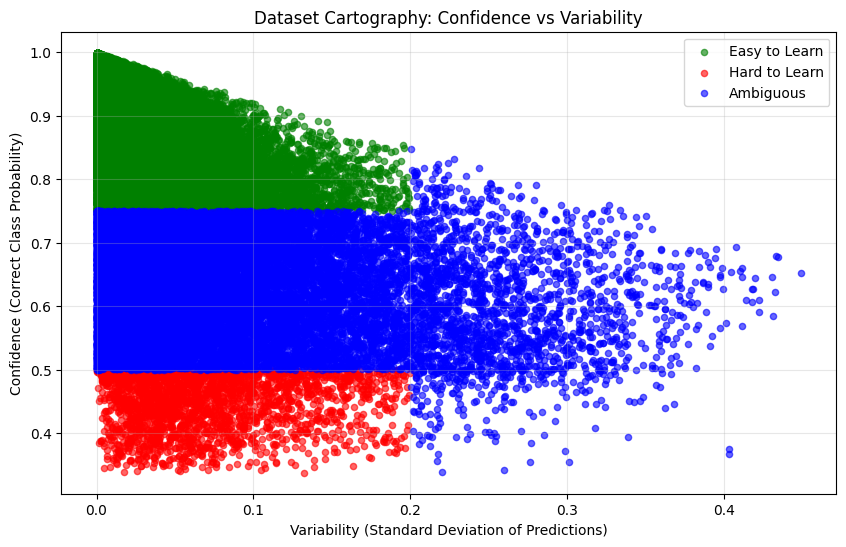

In [32]:
easy_examples = easy_to_learn
hard_examples = hard_to_learn
ambiguous_examples = ambiguous

plt.figure(figsize=(10, 6))

# Plot points for each category
plt.scatter(
    [variability[i] for i in easy_indices],
    [confidences[0][i] for i in easy_indices],
    c="green", label="Easy to Learn", alpha=0.6, s=20
)

plt.scatter(
    [variability[i] for i in hard_examples],
    [confidences[0][i] for i in hard_examples],
    c="red", label="Hard to Learn", alpha=0.6, s=20
)

plt.scatter(
    [variability[i] for i in ambiguous_examples],
    [confidences[0][i] for i in ambiguous_examples],
    c="blue", label="Ambiguous", alpha=0.6, s=20
)

# Add labels and legend
plt.title("Dataset Cartography: Confidence vs Variability")
plt.ylabel("Confidence (Correct Class Probability)")
plt.xlabel("Variability (Standard Deviation of Predictions)")


# Change 'x' to 'y' for axhline to specify the y-coordinate of the horizontal line
#plt.axhline(y=variability_threshold, color='gray', linestyle='--', alpha=0.5, label="Variability Threshold ("+str(variability_threshold)+")")
# No changes needed for axvline as it correctly uses 'y' for the vertical line's x-coordinate
#plt.axvline(x=confidence_threshold, color='gray', linestyle='--', alpha=0.5, label="Confidence Threshold ("+str(confidence_threshold)+")")
#plt.axvline(y=0.5, color='gray', linestyle='--', alpha=0.5, label="Confidence Threshold (0.5)")
plt.legend()
plt.grid(alpha=0.3)


# Show the plot
plt.show()

In [35]:
ambiguous_dataset = train_dataset.select(ambiguous_indices).to_dict()
hard_dataset = train_dataset.select(hard_indices).to_dict()
easy_dataset = train_dataset.select(easy_indices).to_dict()


output_path = "/content/drive/MyDrive/electra/cartography/cart_final/datasets/"


with open(output_path + "easy_examples_small.json", "w") as f:
    json.dump(easy_dataset, f, indent=4)

with open(output_path + "hard_examples_small.json", "w") as f:
    json.dump(hard_dataset, f, indent=4)

with open(output_path + "ambiguous_examples_small.json", "w") as f:
    json.dump(ambiguous_dataset, f, indent=4)

ambiguous_dataset = train_dataset.select(ambiguous_indices)
dataset_new = {}
print(len(ambiguous_dataset))
with open(output_path + 'ambiguous_examples.json', 'w') as f:
  for i in range(len(ambiguous_dataset)):
      if ambiguous_dataset[i]['label'] == -1 :
        label = 1
      else :
        label = ambiguous_dataset[i]['label']
      dataset_new.update( {
          'premise' : ambiguous_dataset[i]['premise']
          ,'hypothesis' : ambiguous_dataset[i]['hypothesis']
          , 'label' : label
          })

      json.dump(dataset_new, f)
      f.write('\n')

18676


In [13]:
ambiguous_dataset = train_dataset.select(ambiguous_indices)

In [18]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import json
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import wandb
# Step 1: Load the HANS dataset
# Convert to Hugging Face Dataset
# Use 90% for training and 10% for validation


train_dataset = ambiguous_dataset


print(len(train_dataset))


# Load Electra Small model and tokenizer
model_name = "/content/drive/MyDrive/electra/trained_model/"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length", max_length=128)



# Fix labels to ensure compatibility
def fix_label(examples):
    examples['label'] = [abs(int(label)) for label in examples['label']]
    return examples


train_dataset = train_dataset.map(fix_label, batched=True)


# Step 2: Load the Tokenizer
# Replace 'google/electra-base-discriminator' with your model's tokenizer if different

#model = AutoModelForSequenceClassification.from_pretrained(model_name)  # 3 labels for SNLI


train_dataset = train_dataset.map(preprocess_function, batched=True)


# Step 3: Split the Dataset (Optional)


print("Train Data size: ",len(train_dataset))

# Step 4: Load the Pretrained Model
# Replace '/path/to/your/pretrained_model' with the directory where your model is saved
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,  # Path to your pretrained model
    num_labels=3  # HANS has 2 labels: entailment and non-entailment
)

# Step 5: Define Training Arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/",  # Directory to save the fine-tuned model
    learning_rate=5e-5,                   # Fine-tuning learning rate
    per_device_train_batch_size=16,       # Adjust based on GPU memory
    num_train_epochs=1,                   # Number of fine-tuning epochs
    weight_decay=0.01,                    # Regularization
    logging_dir="/content/drive/MyDrive/electra/cartography/cart_final/cart_logs",                 # Directory for logs
    logging_steps=100,                    # Log every 100 steps
    save_total_limit=3,                   # Keep only the last 2 checkpoints
    fp16=True,                            # Enable mixed precision for faster training
    gradient_accumulation_steps=2
)

wandb.init(project="cartography_final")
# Step 6: Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

# Step 7: Start Fine-tuning

trainer.train()

wandb.finish()


# Step 8: Save the Fine-tuned Model
trainer.save_model("/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/")
tokenizer.save_pretrained("/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/")


18679
Train Data size:  18679


<ipython-input-18-08eaf2db7eed>:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


('/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/tokenizer_config.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/special_tokens_map.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/vocab.txt',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/added_tokens.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/tokenizer.json')

Evaluating Fine tuned model

In [19]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset snli --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/

2024-11-28 17:26:18.539706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 17:26:18.562186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 17:26:18.569035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 17:26:19.650716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Filter: 100% 10000/10000 [00:00<00:00, 183542.10 examples/s]
Filter: 100% 10000/10000 [00:00<00:00, 211904.17 examples/s]
Filter: 100% 550152/550152 [00:02<

In [20]:
import numpy as np
import pandas as pd
from datasets import Dataset
import json


def load_jsonl_predictions(file_path):
      json_dataset = []  # Initialize an empty list to store JSON objects
      with open(file_path, 'r') as f:
          for line in f:  # Read the file line by line
              try:
                  data = json.loads(line)  # Parse each line as a JSON object
                  json_dataset.append(data)  # Add the parsed object to the list
              except json.JSONDecodeError as e:
                  print(f"Error decoding JSON: {e}, skipping line: {line}")

      dataset = Dataset.from_list(json_dataset)
      # Example Data (Replace with actual data)
      data = json_dataset

      num_classes = 3  # Number of label classes



      def token_overlap_ratio(premise, hypothesis):
          premise_tokens = set(premise.split())
          hypothesis_tokens = set(hypothesis.split())
          intersection = len(premise_tokens & hypothesis_tokens)
          return intersection / len(premise_tokens)

      # Define Error Classes
      error_classes = {
          "Negation": lambda x: any(word in x["premise"].split(" ") + x["hypothesis"].split(" ") for word in ["not", "no", "never", "without"]),
          "Coreference": lambda x: any(word in x["hypothesis"] for word in ["he", "she", "it", "they"]),
          "Rare Words": lambda x: any(word in x["premise"] for word in ["Higgs", "boson", "quantum"]),
          "Ambiguity": lambda x: any(word in x["hypothesis"] for word in ["something", "someone", "several"]),
          "Long Sentences": lambda x: len(x["premise"].split()) > 10 or len(x["hypothesis"].split()) > 10,
          "High Lexical Overlap": lambda x: token_overlap_ratio(x["premise"], x["hypothesis"]) > 0.7,
      }



      # Initialize Counters
      error_counts = {cls: 0 for cls in error_classes}
      total_counts = {cls: 0 for cls in error_classes}
      error_examples = {cls: [] for cls in error_classes}

      # Process Examples
      for example in data:
          true_label = example['label']
          predicted_label = example['predicted_label']
          is_error = true_label != predicted_label  # Check if the prediction is incorrect

          for cls, rule in error_classes.items():
              if rule(example):  # Check if example matches the error class
                  total_counts[cls] += 1
                  if is_error:
                      error_counts[cls] += 1
                      error_examples[cls].append(example)

      # Calculate Metrics
      error_rates = {cls: (error_counts[cls] / total_counts[cls] * 100 if total_counts[cls] > 0 else 0) for cls in error_classes}
      frequencies = {cls: (total_counts[cls] / len(data) * 100) for cls in error_classes}

      # Create Summary Table
      summary_table = pd.DataFrame({
          "Error Class": list(error_classes.keys()),
          "Frequency (%)": [frequencies[cls] for cls in error_classes],
          "Error Rate (%)": [error_rates[cls] for cls in error_classes],
          "Error Count": [error_counts[cls] for cls in error_classes],
          "Total Count": [total_counts[cls] for cls in error_classes],
      })

      # Display Results
      print(summary_table)


**Results of Pretrained Model**

In [21]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/pretrained_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count  \
0              Negation       1.574883       11.612903           18   
1           Coreference      64.661654       11.329353          721   
2            Rare Words       0.000000        0.000000            0   
3             Ambiguity       1.158301       20.175439           23   
4        Long Sentences      68.258484       10.657934          716   
5  High Lexical Overlap       3.881325        9.162304           35   

   Total Count  
0          155  
1         6364  
2            0  
3          114  
4         6718  
5          382  


**Results of Finetuned model on Ambiguous dataset**

In [22]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/finetuned_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count  \
0              Negation       1.574883       10.322581           16   
1           Coreference      64.661654       11.486486          731   
2            Rare Words       0.000000        0.000000            0   
3             Ambiguity       1.158301       19.298246           22   
4        Long Sentences      68.258484       10.881215          731   
5  High Lexical Overlap       3.881325        8.115183           31   

   Total Count  
0          155  
1         6364  
2            0  
3          114  
4         6718  
5          382  


In [ ]:
dataset = load_dataset("snli")
train_dataset = dataset["train"]
train_dataset = train_dataset.train_test_split(test_size=0.50)["train"]

In [26]:

hard_dataset = train_dataset.select(hard_indices)
print(hard_dataset)


Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 2466
})


In [28]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import json
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import wandb
# Step 1: Load the HANS dataset
# Convert to Hugging Face Dataset
# Use 90% for training and 10% for validation


train_dataset = hard_dataset


print(len(train_dataset))


# Load Electra Small model and tokenizer
model_name = "/content/drive/MyDrive/electra/trained_model/"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length", max_length=128)



# Fix labels to ensure compatibility
def fix_label(examples):
    examples['label'] = [abs(int(label)) for label in examples['label']]
    return examples


train_dataset = train_dataset.map(fix_label, batched=True)


# Step 2: Load the Tokenizer
# Replace 'google/electra-base-discriminator' with your model's tokenizer if different

#model = AutoModelForSequenceClassification.from_pretrained(model_name)  # 3 labels for SNLI


train_dataset = train_dataset.map(preprocess_function, batched=True)


# Step 3: Split the Dataset (Optional)


print("Train Data size: ",len(train_dataset))

# Step 4: Load the Pretrained Model
# Replace '/path/to/your/pretrained_model' with the directory where your model is saved
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,  # Path to your pretrained model
    num_labels=3  # HANS has 2 labels: entailment and non-entailment
)

# Step 5: Define Training Arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/",  # Directory to save the fine-tuned model
    learning_rate=5e-5,                   # Fine-tuning learning rate
    per_device_train_batch_size=16,       # Adjust based on GPU memory
    num_train_epochs=1,                   # Number of fine-tuning epochs
    weight_decay=0.01,                    # Regularization
    logging_dir="/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/",                 # Directory for logs
    logging_steps=100,                    # Log every 100 steps
    save_total_limit=3,                   # Keep only the last 2 checkpoints
    fp16=True,                            # Enable mixed precision for faster training
    gradient_accumulation_steps=2
)

wandb.init(project="cartography_final")
# Step 6: Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

# Step 7: Start Fine-tuning

trainer.train()

wandb.finish()


# Step 8: Save the Fine-tuned Model
trainer.save_model("/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/")
tokenizer.save_pretrained("/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/")


2466


Map:   0%|          | 0/2466 [00:00<?, ? examples/s]

Map:   0%|          | 0/2466 [00:00<?, ? examples/s]

Train Data size:  2466


wandb: Currently logged in as: summiyakhalid (summiyakhalid-the-university-of-texas-at-austin). Use `wandb login --relogin` to force relogin


<ipython-input-28-104ce0eb198e>:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


('/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/tokenizer_config.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/special_tokens_map.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/vocab.txt',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/added_tokens.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/tokenizer.json')

Finetune model on Easy dataset

In [25]:
easy_dataset = train_dataset.select(easy_indices)
print(easy_dataset)

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 253931
})


In [29]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import json
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import wandb
# Step 1: Load the HANS dataset
# Convert to Hugging Face Dataset
# Use 90% for training and 10% for validation


train_dataset = easy_dataset
print(len(train_dataset))


# Load Electra Small model and tokenizer
model_name = "/content/drive/MyDrive/electra/trained_model/"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length", max_length=128)

# Fix labels to ensure compatibility
def fix_label(examples):
    examples['label'] = [abs(int(label)) for label in examples['label']]
    return examples


train_dataset = train_dataset.map(fix_label, batched=True)

# Step 2: Load the Tokenizer
# Replace 'google/electra-base-discriminator' with your model's tokenizer if different
#model = AutoModelForSequenceClassification.from_pretrained(model_name)  # 3 labels for SNLI

train_dataset = train_dataset.map(preprocess_function, batched=True)

# Step 3: Split the Dataset (Optional)

print("Train Data size: ",len(train_dataset))

# Step 4: Load the Pretrained Model
# Replace '/path/to/your/pretrained_model' with the directory where your model is saved
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,  # Path to your pretrained model
    num_labels=3  # HANS has 2 labels: entailment and non-entailment
)

# Step 5: Define Training Arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/",  # Directory to save the fine-tuned model
    learning_rate=5e-5,                   # Fine-tuning learning rate
    per_device_train_batch_size=16,       # Adjust based on GPU memory
    num_train_epochs=1,                   # Number of fine-tuning epochs
    weight_decay=0.01,                    # Regularization
    logging_dir="/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/",                 # Directory for logs
    logging_steps=100,                    # Log every 100 steps
    save_total_limit=3,                   # Keep only the last 2 checkpoints
    fp16=True,                            # Enable mixed precision for faster training
    gradient_accumulation_steps=2
)

wandb.init(project="cartography_final")
# Step 6: Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

# Step 7: Start Fine-tuning

trainer.train()

wandb.finish()


# Step 8: Save the Fine-tuned Model
trainer.save_model("/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/")
tokenizer.save_pretrained("/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/")


253931


Map:   0%|          | 0/253931 [00:00<?, ? examples/s]

Train Data size:  253931


<ipython-input-29-9d9e5d6d1573>:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


('/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/tokenizer_config.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/special_tokens_map.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/vocab.txt',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/added_tokens.json',
 '/content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/tokenizer.json')

Evaluating on fine-tuned model on easy dataset

In [34]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset snli --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/

2024-11-28 18:21:23.959590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 18:21:23.980097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 18:21:23.985961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 18:21:25.507938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing data... (this takes a little bit, should only happen once per dataset)
/content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trai

In [36]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/easy_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count  \
0              Negation       1.574883       12.258065           19   
1           Coreference      64.661654       11.407920          726   
2            Rare Words       0.000000        0.000000            0   
3             Ambiguity       1.158301       16.666667           19   
4        Long Sentences      68.258484       10.628163          714   
5  High Lexical Overlap       3.881325        9.162304           35   

   Total Count  
0          155  
1         6364  
2            0  
3          114  
4         6718  
5          382  


Evaluating on fine-tuned model on hard dataset

In [35]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset snli --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/

2024-11-28 18:23:05.601898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 18:23:05.637389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 18:23:05.647630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 18:23:07.283278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 9842/9842 [00:02<00:00, 4800.20 examples/s]
/content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py:159: FutureWarning: `toke

In [39]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/hard_eval_predictions.jsonl")

            Error Class  Frequency (%)  Error Rate (%)  Error Count  \
0              Negation       1.574883       12.903226           20   
1           Coreference      64.661654       11.407920          726   
2            Rare Words       0.000000        0.000000            0   
3             Ambiguity       1.158301       21.052632           24   
4        Long Sentences      68.258484       10.613278          713   
5  High Lexical Overlap       3.881325        7.068063           27   

   Total Count  
0          155  
1         6364  
2            0  
3          114  
4         6718  
5          382  


# MNLI Datasets Testing

**OOD Dataset**

**Pre-trained Finetuned (Entire Dataset) Model**

In [1]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

python3: can't open file '/content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py': [Errno 2] No such file or directory


In [ ]:
load_jsonl_predictions("/content/drive/MyDrive/electra/cartography/cart_final/model/output/hard_eval_predictions.jsonl")

**Model Fine-tuned on Easy Examaples**

In [ ]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli ---dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_easy/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

**Model Fine-tuned on Ambigous Examples**

In [ ]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_cartography/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/

**Model Fine-tuned on Hard Examples**

In [ ]:
!python3 /content/drive/MyDrive/electra/fp-dataset-artifacts-main/run.py --do_eval --task nli --dataset /content/drive/MyDrive/electra/datasets/mnli.json --model /content/drive/MyDrive/electra/cartography/cart_final/model/Finetuned_hard/ --output_dir /content/drive/MyDrive/electra/cartography/cart_final/model/output/mnli_mismatched/